In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("edotfs/dht11-temperature-and-humidity-sensor-1-day")

print("Path to dataset files:", path)

c:\Users\rober\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 3.90k/3.90k [00:00<00:00, 1.99MB/s]

Extracting files...
Path to dataset files: C:\Users\rober\.cache\kagglehub\datasets\edotfs\dht11-temperature-and-humidity-sensor-1-day\versions\1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import joblib

In [3]:
df = pd.read_csv('./1/log_temp.csv')

In [4]:
df.head()

,3/14/19,19:33:07,T=22.0,H=20.0
0,3/14/19,19:38:10,T=22.0,H=20.0
1,3/14/19,19:43:11,T=22.0,H=26.0
2,3/14/19,19:48:14,T=22.0,H=26.0
3,3/14/19,19:53:15,T=22.0,H=20.0
4,3/14/19,19:58:15,T=22.0,H=23.0


In [5]:
df['Temperature'] = df['Temperature'].str.replace("T=", "")
df['Humidity'] = df['Humidity'].str.replace("H=", "")

df['Temperature'] = pd.to_numeric(df['Temperature'], errors='coerce')
df['Humidity'] = pd.to_numeric(df['Humidity'], errors='coerce')

# Drop rows where conversion failed (i.e., got NaN)
df.dropna(subset=['Temperature', 'Humidity'], inplace=True)

KeyError: 'Temperature'

In [ ]:
numeric_df = df[['Temperature', 'Humidity']]

# Apply KNN Imputer
imputer = KNNImputer(n_neighbors=3)
imputed_values = imputer.fit_transform(numeric_df)

# Put imputed values back into the DataFrame
df[['Temperature', 'Humidity']] = imputed_values

In [ ]:
df.head()

,Date,Time,Temperature,Humidity
0,3/14/19,19:38:10,22.0,20.0
1,3/14/19,19:43:11,22.0,26.0
2,3/14/19,19:48:14,22.0,26.0
3,3/14/19,19:53:15,22.0,20.0
4,3/14/19,19:58:15,22.0,23.0


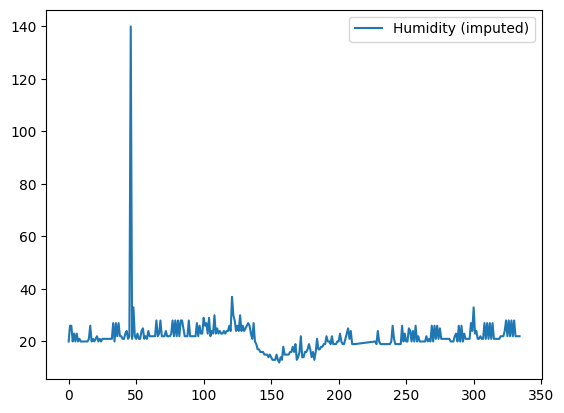

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df['Humidity'], label='Humidity (imputed)')
plt.legend()
plt.show()


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
from sklearn.preprocessing import StandardScaler
X = df[['Temperature', 'Humidity']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['Temperature', 'Humidity']])

iso_forest = IsolationForest(contamination=0.0009, random_state=42)

df['anomaly'] = iso_forest.fit_predict(X_scaled)

In [ ]:
df['anomaly'].value_counts()

anomaly
 1    318
-1      1
Name: count, dtype: int64

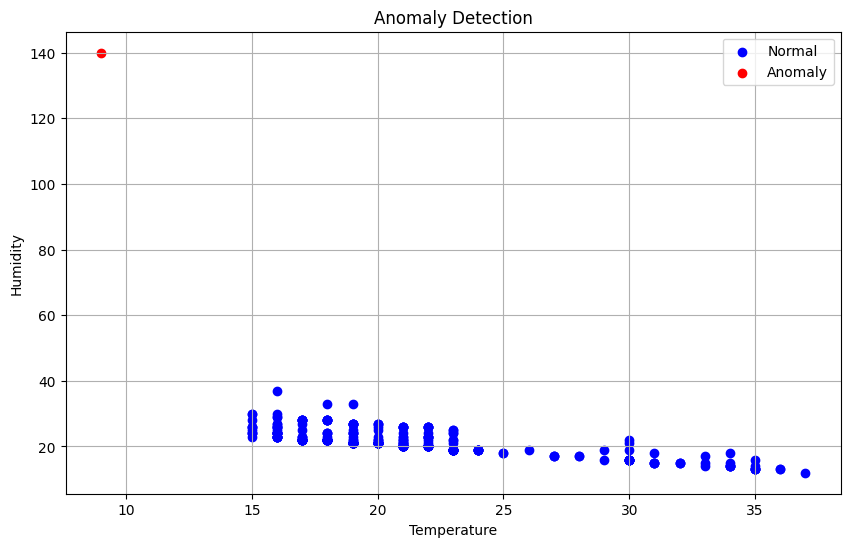

In [ ]:
normal = df[df['anomaly'] == 1]
anomalies = df[df['anomaly'] == -1]

plt.figure(figsize=(10, 6))
plt.scatter(normal['Temperature'], normal['Humidity'], c='blue', label='Normal')
plt.scatter(anomalies['Temperature'], anomalies['Humidity'], c='red', label='Anomaly')
plt.xlabel('Temperature')
plt.ylabel('Humidity')
plt.title('Anomaly Detection')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.0005)

df['lof_anomaly'] = lof.fit_predict(X)

c:\Users\rober\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


In [ ]:
df['lof_anomaly'].value_counts()


lof_anomaly
1    319
Name: count, dtype: int64

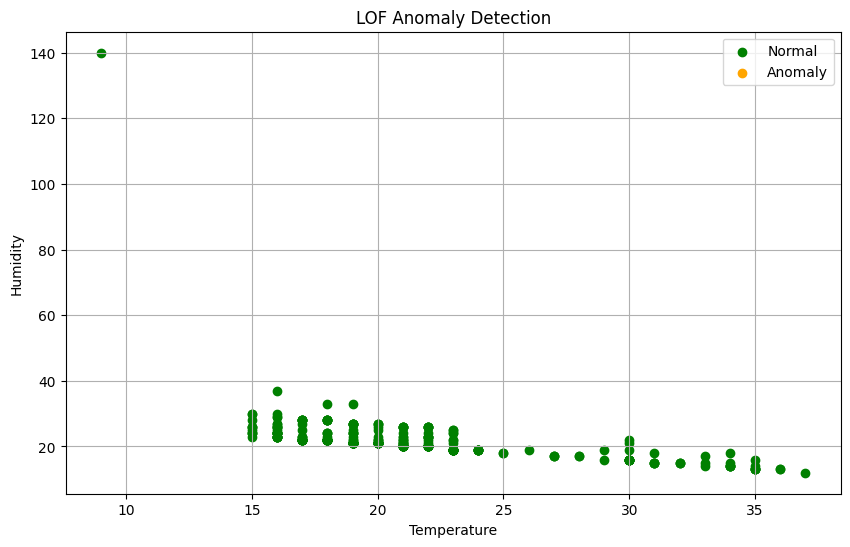

In [ ]:
normal = df[df['lof_anomaly'] == 1]
anomalies = df[df['lof_anomaly'] == -1]

plt.figure(figsize=(10, 6))
plt.scatter(normal['Temperature'], normal['Humidity'], c='green', label='Normal')
plt.scatter(anomalies['Temperature'], anomalies['Humidity'], c='orange', label='Anomaly')
plt.xlabel('Temperature')
plt.ylabel('Humidity')
plt.title('LOF Anomaly Detection')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pickle
with open('iso_forest.pkl', 'wb') as f:
    pickle.dump(iso_forest, f)